In [90]:
import sys
# !{sys.executable} -m pip install gdown h5py
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

In [91]:
path_to_data = '/Users/mverest/Documents/NX_414_Brain_Like_project/' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [92]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

In [94]:
# Flatten images for regression
X_flat_train = stimulus_train.reshape(stimulus_train.shape[0], -1)  # (N_train, 150528)
X_flat_val = stimulus_val.reshape(stimulus_val.shape[0], -1)  # (N_val, 150528) 
Y_train = spikes_train  # (N_train, 100)
Y_val = spikes_val  # (N_val, 100)

In [95]:
def compute_pearson_per_neuron(Y_val, Y_pred = Y_val):
    return np.array([
        pearsonr(Y_val[:, i], Y_pred[:, i])[0] for i in range(Y_val.shape[1])
    ])

def summarize(arr):
    p25 = np.percentile(arr, 25)
    med = np.median(arr)
    p75 = np.percentile(arr, 75)
    return {"P25": p25, "median": med, "P75": p75}

def eval_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    ev = explained_variance_score(y_val, y_pred, multioutput="raw_values")
    r  = compute_pearson_per_neuron(y_val, y_pred)

    return y_pred, summarize(ev), summarize(r)



def plot_performance_metrics(Y_pred, model_name, Y_val=Y_val, verbose = True):
    explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
    corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)

    if verbose:
        print(f"Explained Variance ({model_name}): {explained_var.mean():.4f}")
        print(f"Mean Pearson Correlation ({model_name}): {corr_per_neuron.mean():.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Explained variance 
    sns.histplot(explained_var, bins=30, kde=True, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Explained Variance ({model_name})")
    axes[0].set_xlabel("Explained Variance")
    axes[0].set_ylabel("Number of Neurons")

    # Pearson correlation
    sns.histplot(corr_per_neuron, bins=30, kde=True, color="salmon", ax=axes[1])
    axes[1].set_title(f"Pearson Correlation ({model_name})")
    axes[1].set_xlabel("Pearson Correlation")
    axes[1].set_ylabel("Number of Neurons")

    plt.tight_layout()
    plt.show()
    
    
def boxplot_performance_metrics(list_pred, list_model_name, Y_val):
    ev = {}
    r = {}
    for i, Y_pred in enumerate(list_pred):
        model_name = list_model_name[i]
        explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
        corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)
        ev[model_name] = explained_var
        r[model_name] = corr_per_neuron

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Explained variance 
    axes[0].boxplot(list(ev.values()),  tick_labels=list(r.keys()))
    axes[0].set_ylabel("Explained Variance")
    # axes[0].set_ylim(-1, 1)

    # Pearson correlation
    axes[1].boxplot(list(r.values()), tick_labels=list(r.keys()))
    axes[1].set_ylabel("Pearson Correlation")
    # axes[1].set_ylim(-1, 1)

    plt.tight_layout()
    plt.show()

# Linear Baseline

/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=4.35804e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


,OLS,Ridge
EV,"{'P25': -0.1194324791431427, 'median': -0.0495...","{'P25': -1.1368327140808105, 'median': -0.8669..."
r,"{'P25': 0.1316477544605732, 'median': 0.199738...","{'P25': 0.09127789549529552, 'median': 0.16190..."


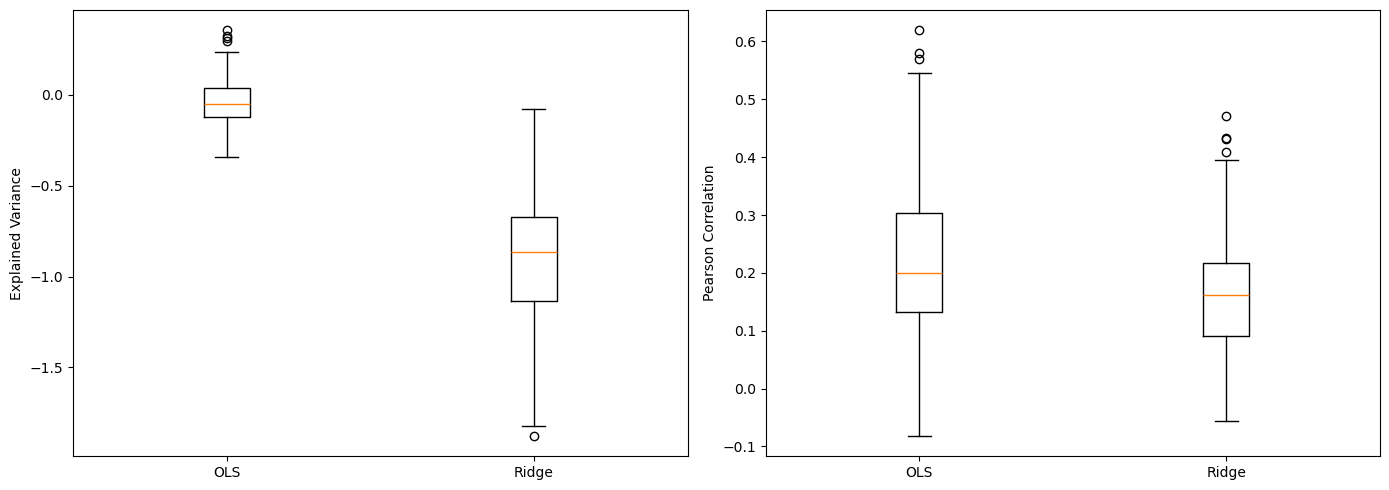

In [96]:
baselines = {
    "OLS":   make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=10))
}


results, predictions = {}, {}

for name, pipe in baselines.items():
    y_hat, ev_str, r_str = eval_model(pipe, X_flat_train, Y_train, X_flat_val, Y_val)
    predictions[name]   = y_hat
    results[name]       = {"EV": ev_str, "r": r_str}
    # print(f"{name:<4} | EV {ev_str} | r {r_str}")


          # dict with formatted summaries
y_pred_OLS  = predictions["OLS"]
y_pred_Ridge = predictions["Ridge"]
results = pd.DataFrame(results)
display(results)

# plot_performance_metrics(y_pred_OLS, "OLS")
# plot_performance_metrics(y_pred_Ridge, "Ridge")
boxplot_performance_metrics([y_pred_OLS, y_pred_Ridge], ["OLS", "Ridge"], Y_val)

# CV alpha and K

In [97]:
X = X_flat_train
Y= Y_train
X_val = X_flat_val
Y_val = Y_val
# pca_dims = np.arange(500, 2000, 500)
# pca_dims = pca_dims[pca_dims != 2000]  
# pca_dims = np.append(pca_dims, [300,661])
pca_dims = [500,661, 1000]
alphas   = np.logspace(-1, 4, num=5)
pca_dims 
alphas = [1000,10000, 100000, 1000000]

In [ ]:
X = X_flat_train
Y= Y_train
X_val = X_flat_val
Y_val = Y_val
# pca_dims = np.arange(500, 2000, 500)
# pca_dims = pca_dims[pca_dims != 2000]  
# pca_dims = np.append(pca_dims, [300,661])
# alphas   = np.logspace(-3, 3, num=5)
pca_dims = [1000, 1500, 2000]
alphas = [ 1000000, 10000000, 100000000]
display(alphas, pca_dims)


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
best_evs   = -np.inf
best_params = {}
results = []
print("Starting CV")

ev_scores = []
for n_comp in pca_dims:
    for alpha in alphas:
        ev_folds = []
        r_folds  = []

        for train_idx, val_idx in cv.split(X, objects_train):
            X_tr, X_cv = X[train_idx], X[val_idx]
            y_tr, y_cv = Y[train_idx], Y[val_idx]

            # fresh pipeline each fold
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_cv = scaler.transform(X_cv)

            pca = PCA(n_components=n_comp, random_state=42)
            X_tr = pca.fit_transform(X_tr)
            X_cv = pca.transform(X_cv)

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_cv)

            ev  = explained_variance_score(y_cv, y_pred,
                                           multioutput='raw_values')
            r   = compute_pearson_per_neuron(y_cv, y_pred)

            ev_folds.append(np.median(ev))
            r_folds.append(np.median(r))

        mean_evs = np.mean(ev_folds)
        mean_r  = np.mean(r_folds)
        # … store results …
        
        results.append({
            'n_components':     n_comp,
            'alpha':            alpha,
            'cv_mean_evs':      mean_evs,
            'cv_mean_corr':     mean_r,
        })

        if mean_evs > best_evs:
            best_evs    = mean_evs
            best_params = {'n_components': n_comp, 'alpha': alpha}

print("\nBest CV params (by EVS):")
print(f"  n_components = {best_params['n_components']}")
print(f"  alpha        = {best_params['alpha']:.3f}")
print(f"  CV EVS       = {best_evs:.4f}")




[1000, 10000, 100000, 1000000]

[500, 661, 1000, 1500]

Starting CV

Best CV params (by EVS):
  n_components = 1500
  alpha        = 1000000.000
  CV EVS       = 0.0557


In [100]:
results = pd.DataFrame(results)
results = results.sort_values(by='cv_mean_evs', ascending=False)
results 

,n_components,alpha,cv_mean_evs,cv_mean_corr
15,1500,1000000,0.055702,0.240443
11,1000,1000000,0.055372,0.239788
7,661,1000000,0.055180,0.238656
3,500,1000000,0.054928,0.237662
14,1500,100000,0.047399,0.242954
10,1000,100000,0.045420,0.239359
6,661,100000,0.044249,0.236284
2,500,100000,0.044098,0.233755
1,500,10000,-0.018760,0.209266
5,661,10000,-0.035940,0.209973


Test optimal model using : Best alpha: 100000, n_components: 661
----------------------------------------------------------------




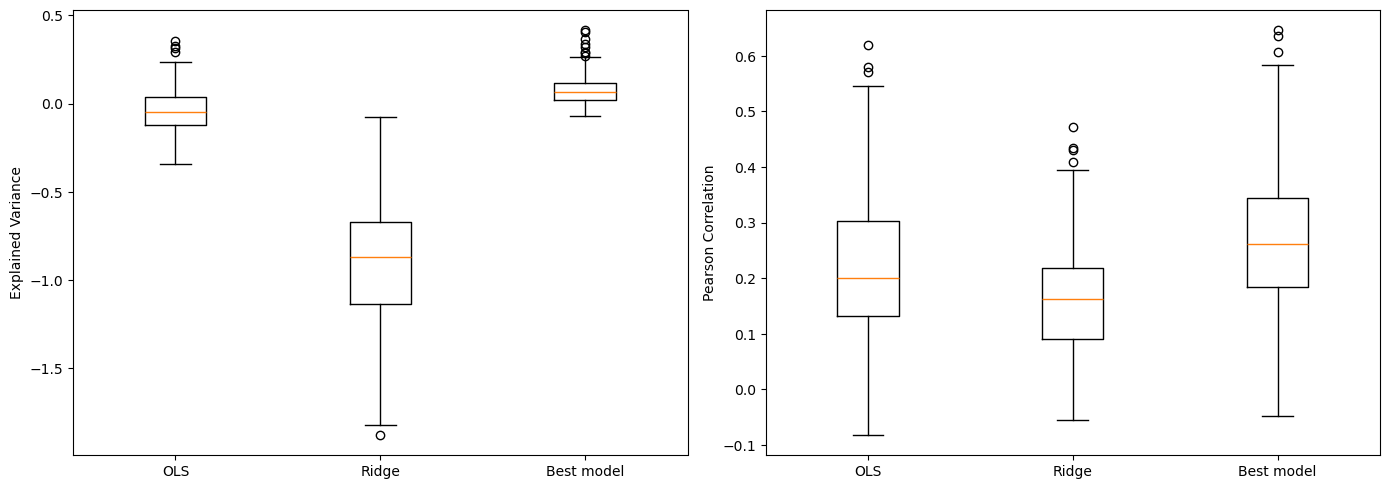

,P25,median,P75
0,0.018767,0.064275,0.116496


,P25,median,P75
0,0.184407,0.261203,0.344965


In [76]:
best_alpha = best_params['alpha']
best_n_comp = best_params['n_components']
# best_alpha = 100000
# best_n_comp = 1000
print(f"Test optimal model using : Best alpha: {best_alpha}, n_components: {best_n_comp}\n----------------------------------------------------------------\n\n")
best_model = make_pipeline(StandardScaler(), PCA(n_components=best_n_comp), Ridge(alpha=best_alpha))
best_model.fit(X_flat_train, Y_train)
y_pred_best = best_model.predict(X_flat_val)
boxplot_performance_metrics([y_pred_OLS, y_pred_Ridge, y_pred_best], ["OLS", "Ridge", "Best model"], Y_val)

ev = explained_variance_score(Y_val, y_pred_best, multioutput="raw_values")
r  = compute_pearson_per_neuron(Y_val, y_pred_best)

display(pd.DataFrame([summarize(ev)]), pd.DataFrame([summarize(r)]))



# Freezed Weight of ResNet50